In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Features engineering
## Input: transactions dataset (name: transactions 2018)
## Output: dataset with features for profiling normalized (name: data)

In [2]:
df=pd.read_csv("df18_ts.csv")
df.head()

,Account_No,DATE,index,year,month,day,withd_by_date,dep_by_date,Balance_updated
0,1196428',2018-01-01,15391,2018,1,1,35000000.00,35625026.51,-1.322909e+08
1,1196428',2018-01-02,15410,2018,1,2,59400000.00,59475597.57,-1.322153e+08
2,1196428',2018-01-03,15437,2018,1,3,43502723.23,53268900.67,-1.224491e+08
3,1196428',2018-01-04,15463,2018,1,4,40300000.00,35910802.21,-1.268383e+08
4,1196428',2018-01-05,15489,2018,1,5,44001591.01,44242137.04,-1.265977e+08


In [3]:
profiling_df=df.drop(["index","Account_No","DATE","year","month","day","Balance_updated"], axis=1)

In [6]:
profiling_df.head()

,withd_by_date,dep_by_date
0,35000000.00,35625026.51
1,59400000.00,59475597.57
2,43502723.23,53268900.67
3,40300000.00,35910802.21
4,44001591.01,44242137.04


In [7]:
profiling_df.skew()

withd_by_date    6.008284
dep_by_date      3.682312
dtype: float64

In [8]:
# profiling_df['withd_by_date']=np.log(profiling_df['withd_by_date']+1)
# profiling_df['dep_by_date']=np.log(profiling_df['dep_by_date']+1)

In [9]:
profiling_df.skew()

withd_by_date    6.008284
dep_by_date      3.682312
dtype: float64

In [10]:
#Standarize features values to apply clustering methods
def df_clustering_std(df_clustering):
    features=list(df_clustering.columns)
    x = df_clustering.loc[:, features].values
    #Standardizing the features
    x = StandardScaler().fit_transform(x)
    d=df_clustering
    d[features] =x
    return d

In [11]:
data=df_clustering_std(profiling_df)

In [12]:
data.head()

,withd_by_date,dep_by_date
0,0.964484,1.099753
1,2.023054,2.233820
2,1.333366,1.938699
3,1.194419,1.113341
4,1.355009,1.509487


# Clustering model
## Input: dataset data
## Output:  number of clusters (k)
## +  Centroids coordinates (centroids)
## + Cluster of each point (labels)

In [13]:
def plot_k(df_clustering_std):
    features=list(df_clustering_std.columns)
    X1 = df_clustering_std[features].iloc[: , :].values
    inertia = []
    for n in range(1 , 11):
        algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
        algorithm.fit(X1)
        inertia.append(algorithm.inertia_)

    #Selecting N Clusters based in Inertia (Squared Distance between Centroids and data points, should be less)
    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(1 , 11) , inertia , 'o')
    plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    return plt.show()

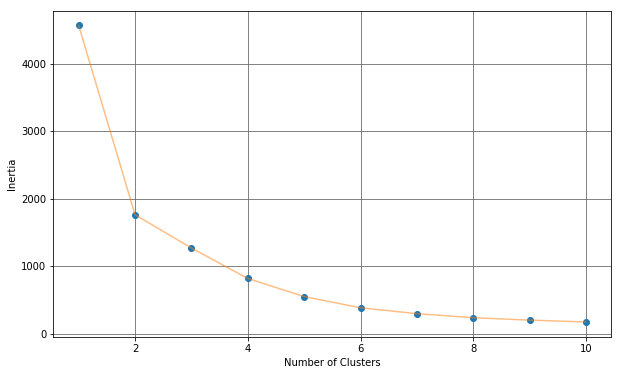

In [14]:
plot_k(data)

In [15]:
def kmeans(df_clustering_std,k):
    features=list(df_clustering_std.columns)
    algorithm = (KMeans(n_clusters = k ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
    X1 = df_clustering_std[features].iloc[: , :].values
    algorithm.fit(X1)
    labels = algorithm.labels_
    centroids = algorithm.cluster_centers_
    labelsncentroids=[labels,centroids]
    return labelsncentroids

In [16]:
k=3
labels=kmeans(data,3)[0]
centroids=kmeans(data,3)[1]

# Centroids table

In [17]:
centroids_table=pd.DataFrame()
centroids_table["profils"]=list(range(0,k))

In [18]:
# data.head()

In [19]:
# list(centroids)[0][2]

In [20]:
# list(centroids)
data.head(1)

,withd_by_date,dep_by_date
0,0.964484,1.099753


In [21]:
# ADD Centroids coordinates for each cluster (profile)
a=[]
for i in range(len(list(centroids))):
    a.append(list(centroids)[i][0])
centroids_table["withd_by_date"]=a

b=[]
for i in range(len(list(centroids))):
    b.append(list(centroids)[i][1])
centroids_table["dep_by_date"]=b



In [22]:
centroids_table

,profils,withd_by_date,dep_by_date
0,0,1.525772,1.751232
1,1,-0.351490,-0.382104
2,2,17.149945,-0.286601


In [23]:
list(centroids)[0][0]

1.5257717914427606

In [24]:
# add cluster number to each point in data and df
data["cluster"]=labels
df["cluster"]=labels

In [25]:
data["Account_No"]=df["Account_No"]

In [26]:
data.head(1)

,withd_by_date,dep_by_date,cluster,Account_No
0,0.964484,1.099753,0,1196428'


In [27]:
df["Account_No"].unique()

array(["1196428'", "1196711'", "409000362497'", "409000405747'",
       "409000425051'", "409000438611'", "409000438620'", "409000493201'",
       "409000493210'", "409000611074'", 'A', 'B'], dtype=object)

In [28]:
df[df["Account_No"]== 'A']["cluster"].value_counts()

1    73
Name: cluster, dtype: int64

# Scores computing
## Input: dataset data
##  Output: df with scores and sub-scores variables


### 1) Get cluster (profile) number for each client

In [29]:
clients=list(df["Account_No"].unique())

In [30]:
# for acc in clients:
#     print(acc)
#     print(data[data["Account_No"]==acc]["cluster"].value_counts())

In [31]:
#add the variable cluster_max to dataset data

data['cluster_max']=0
for acc in clients:
    cond=data["Account_No"]==acc
    data['cluster_max']=data['cluster_max'].mask(cond, data[cond]["cluster"].value_counts().index[0])

In [32]:
data.head(1)

,withd_by_date,dep_by_date,cluster,Account_No,cluster_max
0,0.964484,1.099753,0,1196428',0


In [33]:
centroids_table.head(1)

,profils,withd_by_date,dep_by_date
0,0,1.525772,1.751232


In [34]:
#add coordinates of centroids of cluster_max to dataset data:

# data['cluster_max']=0
data["Withdrawal_centroid"]=0
data["Deposit_centroid"]=0



for i in range(len(centroids_table)):
    
    withd_by_date_0=centroids_table["withd_by_date"][i]
    dep_by_date_0=centroids_table["dep_by_date"][i]
#     month_centroid_0=centroids_table["month_score"][i]
#     day_centroid_0=centroids_table["day_score"][i]
#     dayofweek_centroid_0=centroids_table["dayofweek_score"][i]
#     quarter_centroid_0=centroids_table["quarter_score"][i]
    
    cond=data["cluster_max"]==i
    
    data['Withdrawal_centroid']=data["Withdrawal_centroid"].mask(cond,withd_by_date_0)
    data['Deposit_centroid']=data["Deposit_centroid"].mask(cond,dep_by_date_0)
#     data['month_centroid']=data["month_centroid"].mask(cond,month_centroid_0)
#     data['day_centroid']=data["day_centroid"].mask(cond,day_centroid_0)
#     data['dayofweek_centroid']=data["dayofweek_centroid"].mask(cond,dayofweek_centroid_0)
#     data['quarter_centroid']=data["quarter_centroid"].mask(cond,quarter_centroid_0)


In [35]:
data.head()

,withd_by_date,dep_by_date,cluster,Account_No,cluster_max,Withdrawal_centroid,Deposit_centroid
0,0.964484,1.099753,0,1196428',0,1.525772,1.751232
1,2.023054,2.233820,0,1196428',0,1.525772,1.751232
2,1.333366,1.938699,0,1196428',0,1.525772,1.751232
3,1.194419,1.113341,0,1196428',0,1.525772,1.751232
4,1.355009,1.509487,0,1196428',0,1.525772,1.751232


In [36]:
# centroids_table

### 2) Use the centroids of cluster_max to compute distance between points and centroid

In [37]:
data.head(1)

,withd_by_date,dep_by_date,cluster,Account_No,cluster_max,Withdrawal_centroid,Deposit_centroid
0,0.964484,1.099753,0,1196428',0,1.525772,1.751232


In [38]:
data["withdrawal_score"]=(data["withd_by_date"]-data["Withdrawal_centroid"])**2
data["deposit_score"]=((data["dep_by_date"]- data["Deposit_centroid"]))**2
# data["month_score"]=np.abs(data["month"]- data["month_centroid"])
# data["day_score"]=np.abs(data["day"]- data["day_centroid"])
# data["dayofweek_score"]=np.abs(data["dayofweek"]- data["dayofweek_centroid"])
# data["quarter_score"]=np.abs(data["quarter"]- data["quarter_centroid"])

data["transaction_score"]=np.sqrt(data["withdrawal_score"]+data["deposit_score"])
# +data["month_score"]+data["day_score"]+data["dayofweek_score"]+data["quarter_score"]

In [39]:
data.head(1)

,withd_by_date,dep_by_date,cluster,Account_No,cluster_max,Withdrawal_centroid,Deposit_centroid,withdrawal_score,deposit_score,transaction_score
0,0.964484,1.099753,0,1196428',0,1.525772,1.751232,0.315044,0.424425,0.859924


In [40]:
# Add the variable "is_normal" THAT takes 1 if the transaction is normal according to the clustering (its cluster is the cluster_max ) and takes 0 if not
cond= data["cluster_max"]== data["cluster"]
data["is_normal"]=0
data["is_normal"]= data["is_normal"].mask(cond,1)

In [41]:
data.head()

,withd_by_date,dep_by_date,cluster,Account_No,cluster_max,Withdrawal_centroid,Deposit_centroid,withdrawal_score,deposit_score,transaction_score,is_normal
0,0.964484,1.099753,0,1196428',0,1.525772,1.751232,0.315044,0.424425,0.859924,1
1,2.023054,2.233820,0,1196428',0,1.525772,1.751232,0.247289,0.232891,0.692950,1
2,1.333366,1.938699,0,1196428',0,1.525772,1.751232,0.037020,0.035144,0.268633,1
3,1.194419,1.113341,0,1196428',0,1.525772,1.751232,0.109795,0.406905,0.718818,1
4,1.355009,1.509487,0,1196428',0,1.525772,1.751232,0.029160,0.058441,0.295975,1


In [42]:
data[data["Account_No"]==clients[11]] ["is_normal"].value_counts()

1    75
Name: is_normal, dtype: int64

### 3) Add thresholds

In [43]:
profiles=list(data["cluster_max"].unique())

In [44]:
profiles

[0, 1]

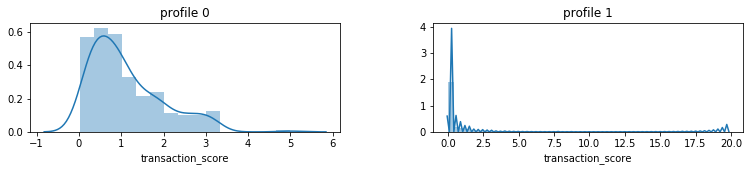

In [45]:
plt.figure(1 , figsize = (20 , 5))
n = 0 
for x in profiles:
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.distplot(data[data["cluster_max"]==x]["transaction_score"])

    plt.title( "profile " + str(x) )
plt.show()



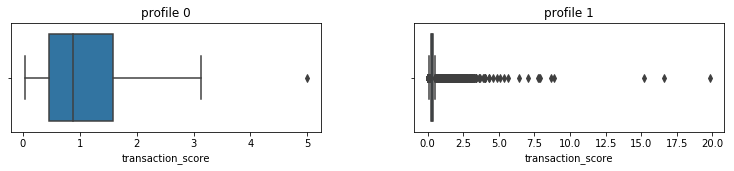

In [46]:
plt.figure(1 , figsize = (20 , 5))
n = 0 
for x in profiles:
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.boxplot(x=data[data["cluster_max"]==x]["transaction_score"])


    plt.title( "profile " + str(x) )
plt.show()


In [47]:
# Point on the outliers in each profile
# q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)


In [48]:
# data["risk_is_medium"]=0
# q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)
# cond_q=data[data["cluster_max"]==x]["transaction_score"]>q3
# data["risk_is_medium"]=data["risk_is_medium"].mask(cond_q,1)

In [49]:
data["q3_threshold"]=0

for x in profiles:
    cond_q=data["cluster_max"]==x
    q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)
    data["q3_threshold"]=data["q3_threshold"].mask(cond_q,q3)

In [50]:
data.head()

,withd_by_date,dep_by_date,cluster,Account_No,cluster_max,Withdrawal_centroid,Deposit_centroid,withdrawal_score,deposit_score,transaction_score,is_normal,q3_threshold
0,0.964484,1.099753,0,1196428',0,1.525772,1.751232,0.315044,0.424425,0.859924,1,1.58378
1,2.023054,2.233820,0,1196428',0,1.525772,1.751232,0.247289,0.232891,0.692950,1,1.58378
2,1.333366,1.938699,0,1196428',0,1.525772,1.751232,0.037020,0.035144,0.268633,1,1.58378
3,1.194419,1.113341,0,1196428',0,1.525772,1.751232,0.109795,0.406905,0.718818,1,1.58378
4,1.355009,1.509487,0,1196428',0,1.525772,1.751232,0.029160,0.058441,0.295975,1,1.58378


In [51]:
np.max(data[data["cluster_max"]==x]["transaction_score"])

19.80891335032331

In [52]:
data["max_threshold"]=0

for x in profiles:
    cond_max=data["cluster_max"]==x
    maxi=np.max(data[data["cluster_max"]==x]["transaction_score"])
    data["max_threshold"]=data["max_threshold"].mask(cond_max,maxi)

In [53]:
data["month"]=df["month"]

In [54]:
data.head(1)


,withd_by_date,dep_by_date,cluster,Account_No,cluster_max,Withdrawal_centroid,Deposit_centroid,withdrawal_score,deposit_score,transaction_score,is_normal,q3_threshold,max_threshold,month
0,0.964484,1.099753,0,1196428',0,1.525772,1.751232,0.315044,0.424425,0.859924,1,1.58378,4.987593,1


In [55]:
scores=pd.DataFrame()
scores[["Account_No","month","cluster_max","withdrawal_score","deposit_score",
        "transaction_score","is_normal","q3_threshold","max_threshold"]]=data[["Account_No","month","cluster_max","withdrawal_score","deposit_score",
                                                                                                                                         "transaction_score","is_normal","q3_threshold","max_threshold"]]

In [56]:
scores.to_csv ('ts_transactions_scores_2.1.csv', index = None, header=True)


In [57]:
# clients
data["Account_No"][data["cluster_max"]==5].value_counts()

Series([], Name: Account_No, dtype: int64)

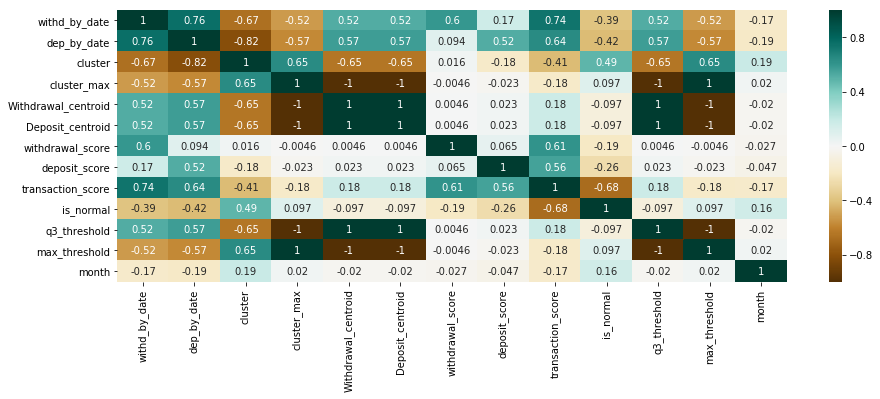

In [58]:
plt.figure(figsize=(15,5))
c= data.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

In [59]:
# scores["month_df"]=df["month"]
# scores['day_df']=df["day"]

In [60]:
scores.head(1)

,Account_No,month,cluster_max,withdrawal_score,deposit_score,transaction_score,is_normal,q3_threshold,max_threshold
0,1196428',1,0,0.315044,0.424425,0.859924,1,1.58378,4.987593
